In [92]:
import sys
sys.path.append("..")
import functools
import pickle

import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import torch
import pyequion2

import tmcdiff

In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
TK = 298.15
bulk_velocity = 1e0
pipe_diameter = 1e-2
species = ["C", "Ca", "Na", "Cl"]
phases = ["Calcite"]
c_nahco3 = 0.018
c_cacl2 = 0.006
c_nacl = 0.003
molal_balance = {'C':c_nahco3, 'Ca':c_cacl2, 'Na':c_nahco3 + c_nacl, 'Cl':2*c_cacl2 + c_nacl}
ngrid = 20
ypmax = 5

In [95]:
solver = tmcdiff.TransportSolver(species)
solver.set_flow_conditions(TK, bulk_velocity, pipe_diameter)
solver.set_initial_conditions(molal_balance, phases)
solver.build_transport(ngrid, ypmax)
solver.set_initial_guess()

In [96]:
eqsys_front = pyequion2.EquilibriumSystem(species, from_elements=True,
                                           activity_model="DEBYE")
sol, _ = eqsys_front.solve_equilibrium_mixed_balance(TK, molal_balance=molal_balance)
sol.saturation_indexes

{'Aragonite': 1.4501980854042777,
 'Calcite': 1.593967932796513,
 'Halite': -5.246831827080137,
 'Vaterite': 1.0275364385822137}

In [98]:
solver.load("data/exp1_a")

Text(0, 0.5, 'c [mol/kg H2O]')

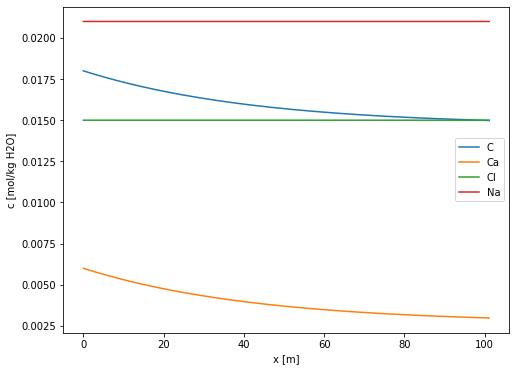

In [99]:
plt.figure(figsize=(8, 6))
for i, el in enumerate(solver.eqsys.solute_elements):
    plt.plot(solver.t*bulk_velocity, solver.x[:, i], label=el)
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("c [mol/kg H2O]")

Text(0, 0.5, 'c [ln (mol/kg H2O)]')

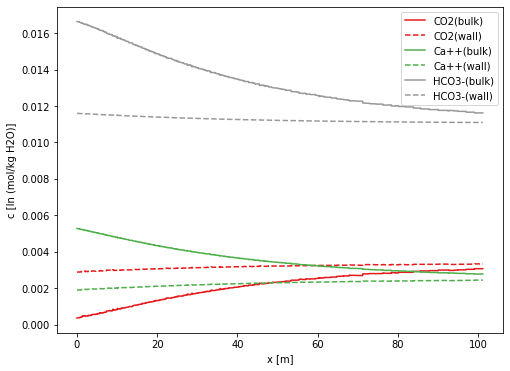

In [100]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("Set1")
for i, el in enumerate(solver.eqsys.solutes):
    if el in ["CO2", "Ca++", "HCO3-"]:
        plt.plot(solver.t*bulk_velocity, np.exp(solver.logc)[:, i, -1], label=el + "(bulk)", color=cmap(i), linestyle='-')
        plt.plot(solver.t*bulk_velocity, np.exp(solver.logc)[:, i, 0], label=el + "(wall)", color=cmap(i), linestyle='--')
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("c [ln (mol/kg H2O)]")

In [101]:
logg = solver.builder.activity_model_func(np.exp(np.moveaxis(solver.logc, -2, -1)), numpy=True)
logg = np.moveaxis(logg, -2, -1)
loga = logg + solver.logc
nu = solver.builder.reduced_reaction_vector.numpy()
logiap = np.einsum("ij, ljm -> lim", nu, loga)
logsatur = logiap - solver.builder.logk_solid[..., None].numpy()

In [102]:
c = np.exp(solver.logc)
A = solver.builder.reduced_formula_matrix
cel = np.einsum("ij, ljm -> lim", A, c)
cel_interp = scipy.interpolate.interp1d(solver.t, cel, axis=0)
cinterp = scipy.interpolate.interp1d(solver.t, c, axis=0)

In [129]:
solver.eqsys.solute_elements
dmdt_molm2s = -solver.fluxes[:, 0] #mol/m2 s
dmdt_kgm2s = dmdt_molm2s*100.0869 #g/m2 s
dmdt_gms = dmdt_molm2s/(np.pi*pipe_diameter)
dmdt_gmh = dmdt_gms*3600

Text(0, 0.5, 'S.I.')

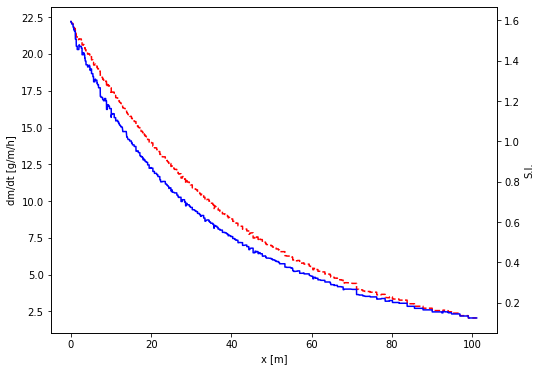

In [136]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(solver.t[1:], dmdt_gmh, 'r--')
ax2.plot(solver.t*bulk_velocity, logsatur[:, 0, -1]/np.log(10), 'b-')
ax1.set_xlabel("x [m]")
ax1.set_ylabel("dm/dt [g/m/h]")
ax2.set_ylabel("S.I.")

Text(0, 0.5, 'S.I.')

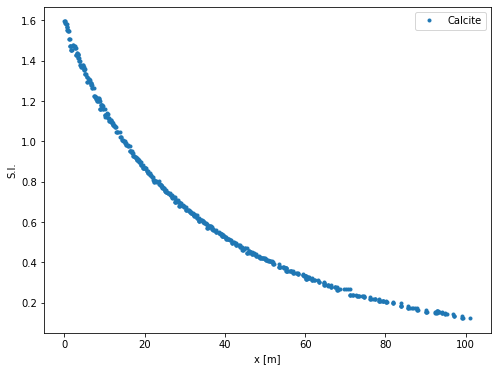

In [91]:
plt.figure(figsize=(8, 6))
for i, phase in enumerate(solver.builder.phases):
    plt.plot(solver.t*bulk_velocity, logsatur[:, i, -1]/np.log(10), label=phase, linestyle=' ',
             marker='.')
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("S.I.")

Text(0, 0.5, 'c [mol/kg H2O]')

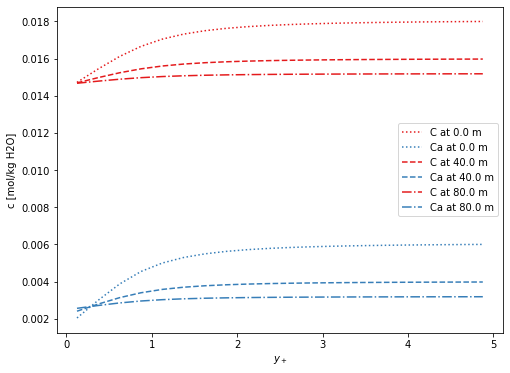

In [68]:
plt.figure(figsize=(8, 6))
t = 40.0
linestyles = [':', '--', '-.']
cmap = plt.get_cmap("Set1")
for j, t in enumerate([0.0, 40.0, 80.0]):
    for i, el in enumerate(solver.eqsys.solute_elements + ['e']):
        if el in ['C', 'Ca']:
            plt.plot(solver.builder.ygrid, cel_interp(t)[i, :],
                     label=f"{el} at {t*bulk_velocity} m",
                     color = cmap(i),
                     linestyle=linestyles[j])
plt.legend()
plt.xlabel(r"$y_+$")
plt.ylabel(r"c [mol/kg H2O]")

Text(0, 0.5, 'c [mol/kg H2O]')

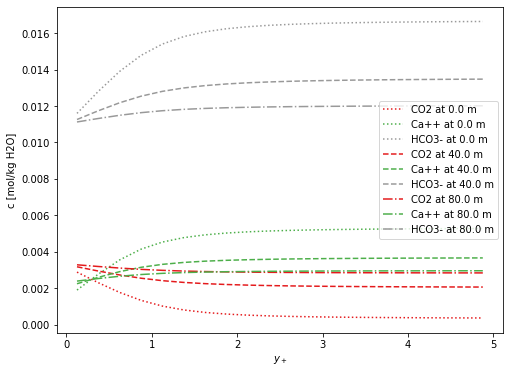

In [69]:
plt.figure(figsize=(8, 6))
t = 40.0
linestyles = [':', '--', '-.']
cmap = plt.get_cmap("Set1")
for j, t in enumerate([0.0, 40.0, 80.0]):
    for i, el in enumerate(solver.eqsys.solutes):
        if el in ["CO2", "Ca++", "HCO3-"]:
            plt.plot(solver.builder.ygrid, cinterp(t)[i, :],
                     label=f"{el} at {t*bulk_velocity} m",
                     color = cmap(i),
                     linestyle=linestyles[j])
plt.legend()
plt.xlabel(r"$y_+$")
plt.ylabel(r"c [mol/kg H2O]")

(703, 20)

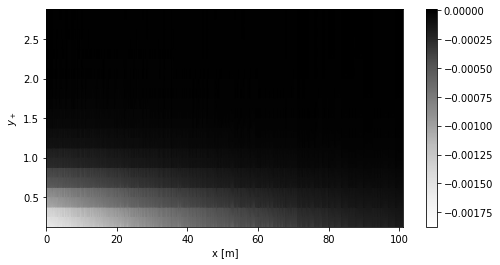

In [90]:
plt.figure(figsize=(8, 4))
T, Y = np.meshgrid(solver.t, solver.builder.ygrid[:12])
c_charge = cel[:, -1, :12]
plot = plt.pcolormesh(T, Y, c_charge.transpose(), cmap='Greys', shading='gouraud')
plt.xlabel("x [m]")
plt.ylabel(r"$y_+$")
plt.colorbar(plot)

(703, 20)